In [1409]:
import pandas as pd
import numpy as np
import os,fnmatch
import xarray as xr
import matplotlib.pylab as plt
from matplotlib import rcParams
from functools import reduce
import seaborn as sns
import scipy.optimize as optimize
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Tahoma']
rcParams['figure.figsize'] = (11.7,8.27)
rcParams['font.size']=13
import katdal
sns.set()

In [875]:
# Loding the basline
bl_len = pd.read_csv('/data/isaac/DR1/meerkatbaselinelengh.csv')
bl_len = bl_len.iloc[:,1:].values[0]
# Baseline index sorted by ascending order
indx = np.argsort(bl_len)
bl_len = bl_len[indx]

In [1470]:
# Choose clean band or all band
band = int(input('if clean and press one or if all band press two :'))

if clean and press one or if all band press two :2


In [1472]:
if band == 1:
    dr1 =np.load('/data/isaac/DR1/montly_mean_Clean_band.npy') 
    dr0= np.load('/data/isaac/DR0/montly_Clean_band_DR0_All_Files.npy')
if band == 2:
    dr1 =np.load('/data/isaac/DR1/montl_mean__per_bl.npy')
    dr0= np.load('/data/isaac/DR0/montly_per_bl_mean.py.npy')
    

In [1474]:
def data_to_use(dr0,dr1,d0=False,d1=False,both=False):
    '''
    Input : dr0,dr1 mean per baseline
    
    Output : Dataset combination or dr1 or dr0
    '''
    Data = []
    data1 = []
    for i in range(len(dr1)):
        Data.append([dr1[i][0],dr1[i][3],dr1[i][2][0:4]+dr1[i][2][5:7]+'05'])
        data1.append([dr1[i][0],dr1[i][3],dr1[i][2][0:4]+dr1[i][2][5:7]+'05'])
        
    for i in range(len(dr0)):
        Data.append([dr0[i][0],dr0[i][1],dr0[i][2]])
    if d0:
        return dr0
    if d1:
        return data1
    if both:
        return Data

In [1475]:
Data = data_to_use(dr0,dr1,both=True,d1=False,d0=False)

In [1476]:
mon = []
tim = []
bl_mean = []
for i in range(len(Data)):
    if str(Data[i][2])[4]=='0':
        mon.append(float(str(Data[i][2])[5]))
        bl_mean.append(Data[i][0].astype(float))
        tim.append(Data[i][1])
    else:
        mon.append(float(str(Data[i][2])[4:6]))
        bl_mean.append(Data[i][0].astype(float))
        tim.append(Data[i][1])

In [1477]:
mon = np.array(mon)
tim = np.array(tim)
bl_mean = np.array(bl_mean)

In [1478]:
def mean_per_month_per_baseline(data,mon,mon_id,tim):
    '''
    This function would group observations per months.
    
    Input : data
    '''
    idx_mon = np.where(mon==mon_id)[0]
    obs = np.zeros((len(idx_mon),2016))
    t = []
    for i,j in enumerate(idx_mon):
        obs[i,:] = data[j][0]
        t.append(tim[j]/60.)


    t = np.array(t)
        
    return obs,t

In [1479]:
obs = np.array([mean_per_month_per_baseline(Data,mon,i,tim)[0] for i in np.unique(mon)])
time_per_mon = np.array([mean_per_month_per_baseline(Data,mon,i,tim)[1] for i in np.unique(mon)])

In [1480]:
def count_min_obs_per_bl(obs,t ):
    '''
    Calculating minimum number of files in a month per baseline
    '''
    count = np.zeros((obs.shape[0],2016))
    for i in range(obs.shape[0]):
        for j in range(2016):
            count[i,j] = len(np.where(~np.isnan(obs[i][:,j]))[0])
    bl_min = np.array([min(count[:,i][np.where(count[:,i]>=3)]) for i in range(count.shape[1])]).astype(int)
    ave_per_mon= []
    for file in range(obs.shape[0]):
        bl_mean = np.zeros((3,2016))
        for bl in range(2016):
            nt_nan_0_idx = np.where((obs[file][:,bl]!=0)&(~np.isnan(obs[file][:,bl])))[0]
            not_nan_obs = obs[file][:,bl][nt_nan_0_idx]
            sample_size = bl_min[file]
            if len(not_nan_obs) < sample_size:
                sample_size = len(not_nan_obs)
            min_obs  = not_nan_obs[np.random.choice(len(not_nan_obs), size=sample_size, replace=False)].ravel()
            tm_idx  = []
            for idx,value in enumerate(not_nan_obs):
                if value in min_obs:
                    tm_idx.append(idx)

            tm =t[file][nt_nan_0_idx][tm_idx]

            weigt_ave = 0
            weight_std = 0
            for ii,v in enumerate(tm):
                weigt_ave += (v/np.sum(tm))*not_nan_obs[ii]

            norm_ave = np.mean(not_nan_obs)
            std = np.std(not_nan_obs)

            bl_mean[:,bl] = [weigt_ave,norm_ave,std]
        ave_per_mon.append(bl_mean)
            
            
    return ave_per_mon

In [1481]:
bl_min = count_min_obs_per_bl(obs,time_per_mon)

## Inverse Weighted Average

Given the probablility of RFI $\theta_i$ and its associated variance $\sigma_i$, we can calculate the inverse weigted probability average as follows: <br>

\begin{eqnarray}
\theta_{AVE} = \frac{\sum_{i} \frac{1}{\sigma_{i}^2} \theta_{i}}{\sum_{i}\frac{1}{\sigma_{i}^2}}
\end{eqnarray}

The variance of inverse weigted average cam be calcalated:

\begin{eqnarray}
D^{2}(\theta_{AVE})  = \frac{1}{\sum_{i}\frac{1}{\sigma_{i}^2}}
\end{eqnarray}

In [1482]:
def INV_VAR_AVE(bl_min):
    mean_weig = []
    standard_mean = []
    std_dev = []
    for i in range(1,len(bl_min)):
        invar = 0
        sum_cons = 0
        invar_std = 0
        idx = np.where((~np.isinf(bl_min[i][0]))&(~np.isnan(bl_min[i][0])&(~np.isinf(bl_min[i][2]))&(~np.isnan(bl_min[i][2])))&(bl_min[i][2]!=0))[0]
        m_bl  = bl_min[i][0][idx]
        std = bl_min[i][2][idx]
        #std_dev.append(np.sum(std)/len(std))
        #print(std)
        standard_mean.append(np.mean(m_bl))
        for j,value in enumerate(m_bl):
            deno = (std[j])**2 
            cons = 1./deno
            invar += cons*value
            sum_cons += cons   
            mean_inv = invar/sum_cons
            
        
        mean_weig.append(mean_inv)
        std_dev.append(1./sum_cons)
    return mean_weig,standard_mean,np.array(std_dev)

In [1483]:
inva_mean, standard_mean,var= INV_VAR_AVE(bl_min)

In [1484]:
std = np.sqrt(var)

In [1485]:
def fit_uncertainity(p,x,y,y_uncer):
    m,c = p
    fit = abs((y - (m*x + c))/(y_uncer))
    return fit

# Initial parameters for A,B and C
p1 = np.array([0.01,0.05])
## Using the leastsq algorithm:
prob = inva_mean
y_uncer = std
month = np.arange(len(inva_mean))
fits1 = optimize.leastsq(fit_uncertainity,p1,args=(month,prob,y_uncer))
## Extracting the best fit parameters from the fits
coeff1 = fits1[0]


In [1486]:
m_err,c_err = coeff1
fit_err = m_err*np.arange(len(inva_mean)) + c_err

In [1487]:
m,c = np.polyfit(np.arange(len(inva_mean)),inva_mean,deg=1)
fit = m*np.arange(len(inva_mean)) + c

In [1488]:
a = inva_mean - np.array(std)
b = inva_mean + np.array(std)

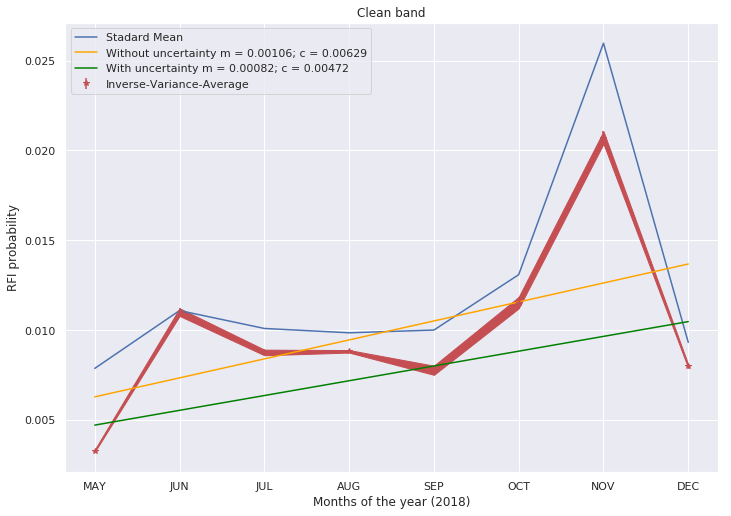

In [1448]:
plt.plot(np.arange(len(inva_mean)),standard_mean,label='Stadard Mean')
plt.errorbar(np.arange(len(inva_mean)),inva_mean,fmt='*r',yerr = std,label='Inverse-Variance-Average')
plt.fill_between(np.arange(len(inva_mean)),a,b,color='r')
plt.plot(fit,color='orange',label=r'Without uncertainty m = '+str(round(m,5))+ '; c = '+str(round(c,5)))
plt.plot(fit_err,color='green',label=r'With uncertainty m = '+str(round(m_err,5))+ '; c = '+str(round(c_err,5)))
plt.xticks(np.arange(8),['MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'])
plt.legend()
plt.ylabel('RFI probability')
plt.xlabel('Months of the year (2018)')
plt.title('Clean band')
plt.show()

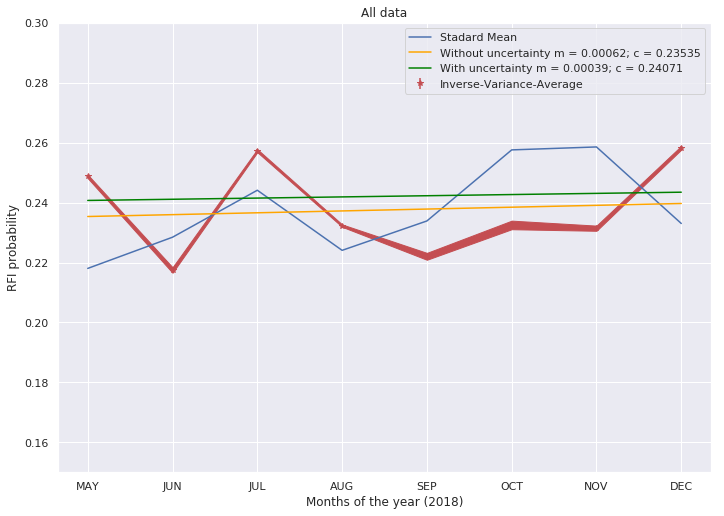

In [1495]:
plt.plot(np.arange(len(inva_mean)),standard_mean,label='Stadard Mean')
plt.errorbar(np.arange(len(inva_mean)),inva_mean,fmt='*r',yerr = std,label='Inverse-Variance-Average')
plt.fill_between(np.arange(len(inva_mean)),a,b,color='r')
plt.plot(fit,color='orange',label=r'Without uncertainty m = '+str(round(m,5))+ '; c = '+str(round(c,5)))
plt.plot(fit_err,color='green',label=r'With uncertainty m = '+str(round(m_err,5))+ '; c = '+str(round(c_err,5)))
plt.xticks(np.arange(8),['MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC'])
plt.legend()
plt.ylim(0.15,0.3)
plt.ylabel('RFI probability')
plt.xlabel('Months of the year (2018)')
plt.title('All data')
plt.show()